In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Load PASCAL VOC dataset
train_dataset = torchvision.datasets.VOCDetection(
    root="./data/pascal",
    year="2012",
    image_set="train",
    download=True,
    transform=transform
)
val_dataset = torchvision.datasets.VOCDetection(
    root="./data/pascal",
    year="2012",
    image_set="val",
    download=True,
    transform=transform
)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))



Using downloaded and verified file: ./data/pascal/VOCtrainval_11-May-2012.tar
Extracting ./data/pascal/VOCtrainval_11-May-2012.tar to ./data/pascal
Using downloaded and verified file: ./data/pascal/VOCtrainval_11-May-2012.tar
Extracting ./data/pascal/VOCtrainval_11-May-2012.tar to ./data/pascal


In [2]:
# pretrained rcnn model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)

# Define loss functions
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def process_targets(targets):
    bbox_list, label_list = [], []
    for target in targets:
        objects = target["annotation"]["object"]
        if not isinstance(objects, list):
            objects = [objects] 
        
        boxes = []
        labels = []
        for obj in objects:
            bbox = [
                float(obj["bndbox"]["xmin"]),
                float(obj["bndbox"]["ymin"]),
                float(obj["bndbox"]["xmax"]),
                float(obj["bndbox"]["ymax"]),
            ]
            boxes.append(bbox)
            labels.append(int(obj["name"]) if obj["name"].isdigit() else 1)
        
        bbox_list.append(torch.tensor(boxes, dtype=torch.float32))
        label_list.append(torch.tensor(labels, dtype=torch.long))
    
    return bbox_list, label_list



/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: ./data/pascal/VOCtrainval_11-May-2012.tar
Extracting ./data/pascal/VOCtrainval_11-May-2012.tar to ./data/pascal


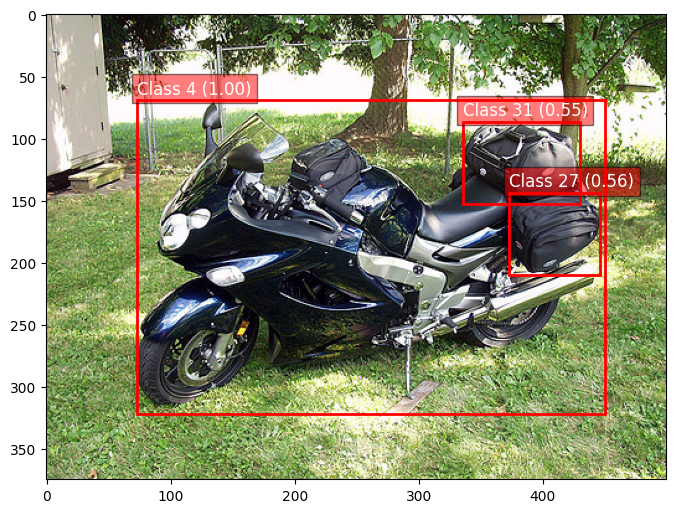

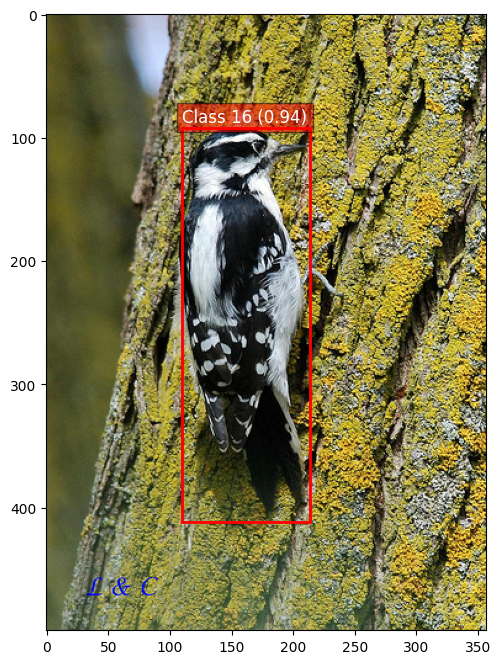

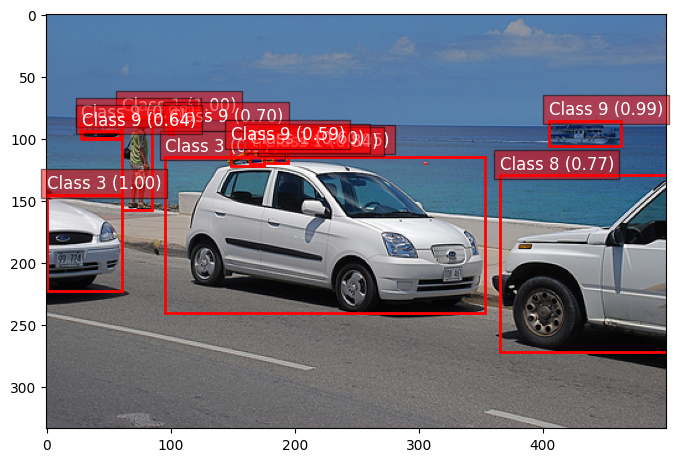

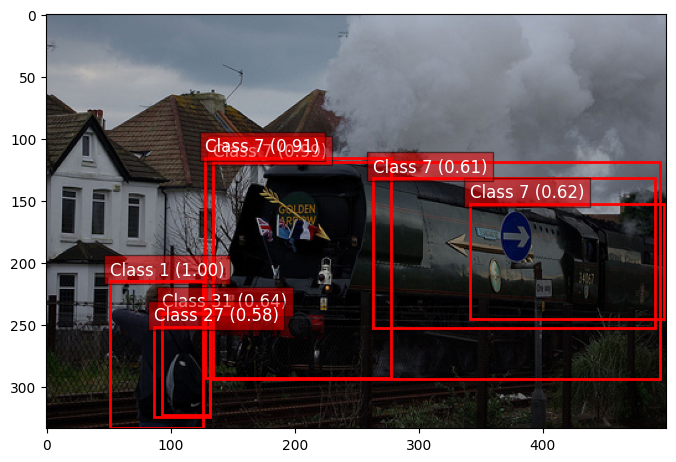

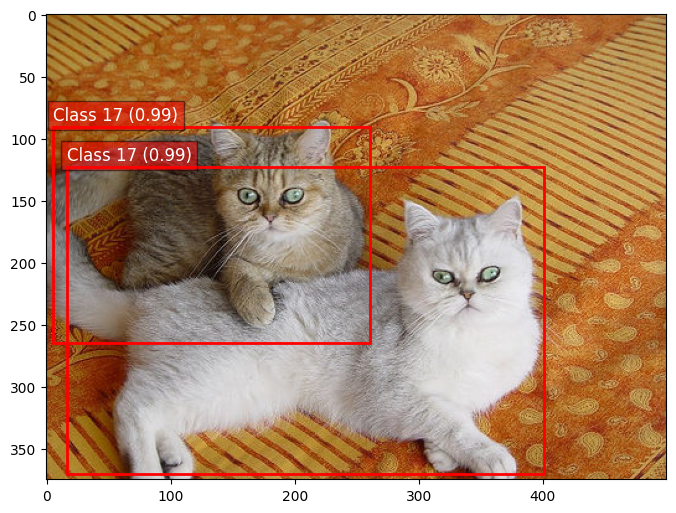

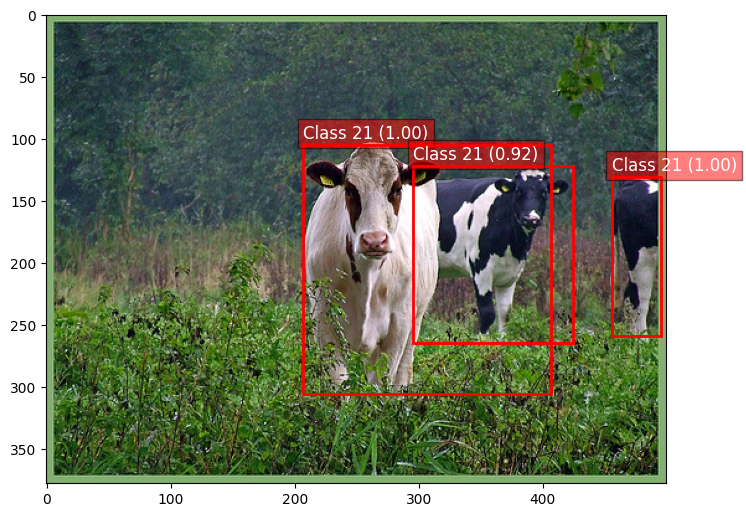

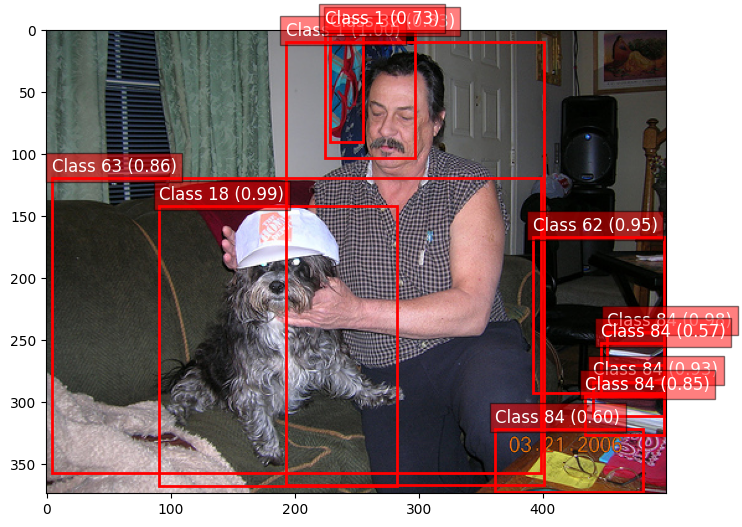

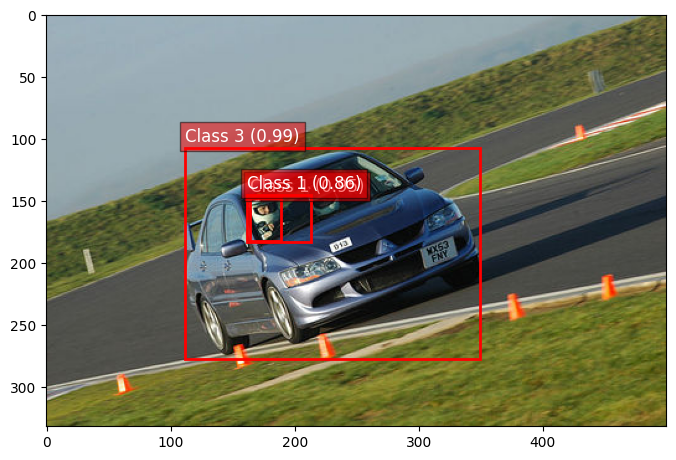

In [3]:
import random
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load test dataset (no annotations)
test_dataset = datasets.VOCDetection(
    root="./data/pascal",
    year="2012",
    image_set="val",
    download=True,
    transform=transforms.ToTensor()
)

# Select 10 random images from test set
random_indices = random.sample(range(len(test_dataset)), 10)
test_images = [test_dataset[i][0] for i in random_indices]  # Ignore annotations

# Move model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Perform inference
with torch.no_grad():
    for i, image in enumerate(test_images):
        img_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
        outputs = model(img_tensor)  # ✅ No need for manual proposals

        # Extract bounding boxes, labels, and scores
        pred_boxes = outputs[0]["boxes"].cpu().numpy()
        pred_labels = outputs[0]["labels"].cpu().numpy()
        pred_scores = outputs[0]["scores"].cpu().numpy()

        # Convert to PIL for visualization
        img_pil = transforms.ToPILImage()(image.cpu())

        # Plot image with bounding boxes
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img_pil)

        # Draw bounding boxes
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score < 0.5:  # Filter out low-confidence predictions
                continue
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin), width, height,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"Class {label} ({score:.2f})", color='white', fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5))

        plt.show()
